# Modelo CNN - Proyecto Júpiter - Inés

In [33]:
#Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 1. Carga y preparación de los datos

In [47]:
#Rutas a las imágenes
test_path = Path('./archive/test/')
train_path = Path('./archive/train/')
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [48]:
#Definir las emociones en una lista
clases = ['surprise', 'happy', 'neutral', 'angry', 'fear', 'sad', 'disgust']

In [49]:
#Hacemos data augmentation
img_size = (48, 48)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalización
    horizontal_flip=True, #da la vuelta horizontalmente
    zoom_range=0.2, #zoom aleatorio de 20%
    rotation_range=20, #rotación aleatoria de 20º
    fill_mode='nearest' #rellena espacios vacío de las modificaciones anteriores
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
# Cargar las imágenes train y test
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical', #conversión a one-hot
    classes = clases,
    shuffle=True #mezclar de manera aleatoria
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes = clases,
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [51]:
# Clasificar numéricamente las clases
num_clases = len(CLASSES)
clases_indices = train_generator.class_indices
print("Número de clases:", num_clases)
print("Clases:", clases_indices)

Número de clases: 7
Clases: {'surprise': 0, 'happy': 1, 'neutral': 2, 'angry': 3, 'fear': 4, 'sad': 5, 'disgust': 6}


Teniendo en cuenta que tenemos este número de imágenes por clase en train, vamos a darle diferentes pesos:
- angry: 3995
- disgust: 436
- fear: 4097
- happy: 7215
- neutral: 4965
- sad: 4830
- surprise: 3171

In [52]:
#Definir los pesos por emoción para el entrenamiento:
counts = {
    'angry': 3995,
    'disgust': 436,
    'fear': 4097,
    'happy': 7215,
    'neutral': 4965,
    'sad': 4830,
    'surprise': 3171
}

total_images = sum(counts.values())
num_classes = len(counts)

weights = {cls: total_images / (num_classes * count) for cls, count in counts.items()}
weights

{'angry': 1.0266046844269623,
 'disgust': 9.406618610747051,
 'fear': 1.0010460615781582,
 'happy': 0.5684387684387684,
 'neutral': 0.8260394187886635,
 'sad': 0.8491274770777877,
 'surprise': 1.293372978330405}

In [53]:
class_weight={
        'angry': 1.0266,
        'disgust': 9.4066,
        'fear': 1.0010,
        'happy': 0.5684,
        'neutral': 0.8260,
        'sad': 0.8491,
        'surprise': 1.2933
    }

## 2. Creación del modelo

In [55]:
model = Sequential()

# 1. Primera capa para extraer características básicas (bordes, texturas)
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())  # Normaliza la capa anterior
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce resolución a la mitad (downsampling)

# 2. Segunda capa para detectar patrones más complejos (formas, esquinas)
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Tercera capa para aprender características más abstractas
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4. Cuarta capa para patrones aún más complejos
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5. Aplanar para pasar de las 3D características a 1D vector
model.add(Flatten())

# 6. Capa densa para aprender combinaciones de características
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar sobreajuste/overfitting

# 7. Capa de salida: 7 neuronas (para 7 emociones), activación softmax para clasificación múltiple
model.add(Dense(7, activation='softmax'))

# Compilamos el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,511 (6.00 MB)

 Trainable params: 1,572,551 (6.00 MB)

 Non-trainable params: 960 (3.75 KB)

## 3. Entrenamiento del modelo

In [56]:
#Técnicas para evitar el sobreaprendizaje:

early_stop = EarlyStopping(monitor='loss', #Detiene el entrenamiento si la métrica no mejora
                           patience=15,  #Espera epoch antes de parar en entrenamiento
                           restore_best_weights=True) #restaura los pesos al mejor epoch

reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, #reduce el learning rate a la mitad
                              patience=15, 
                              verbose=1) #muestra un mensaje cuando reduce la tasa

In [58]:
history = model.fit(
    train_generator,
    epochs=50,
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.1975 - loss: 8.3125 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.2576 - loss: 2.6789 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.3152 - loss: 2.1949 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.3584 - loss: 2.1564 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.3745 - loss: 2.1860 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.3848 - loss: 2.1982 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.3976 - loss: 2.5208 - learning_rate: 0.0010
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.4000 - loss: 2.5136 - learning_rate: 0.0010
Epoch 9/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.4125 - loss: 2.5868 - learning_rate:

## Evaluación del modelo

In [59]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4911 - loss: 1.5770
Test accuracy: 0.36


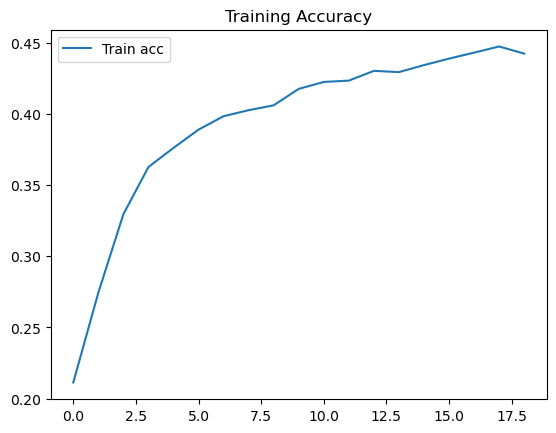

In [60]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [61]:
# Calcular métricas
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=clases))

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.68      0.49      0.57       831
       happy       0.81      0.67      0.73      1774
     neutral       0.57      0.06      0.11      1233
       angry       0.18      0.90      0.30       958
        fear       0.30      0.05      0.09      1024
         sad       0.33      0.00      0.00      1247
     disgust       0.00      0.00      0.00       111

    accuracy                           0.36      7178
   macro avg       0.41      0.31      0.26      7178
weighted avg       0.50      0.36      0.32      7178



/opt/anaconda3/envs/pontia-ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/pontia-ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/pontia-ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [62]:
# Calcular F1-score promedio
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Weighted F1-Score: {f1:.2f}")

Weighted F1-Score: 0.32


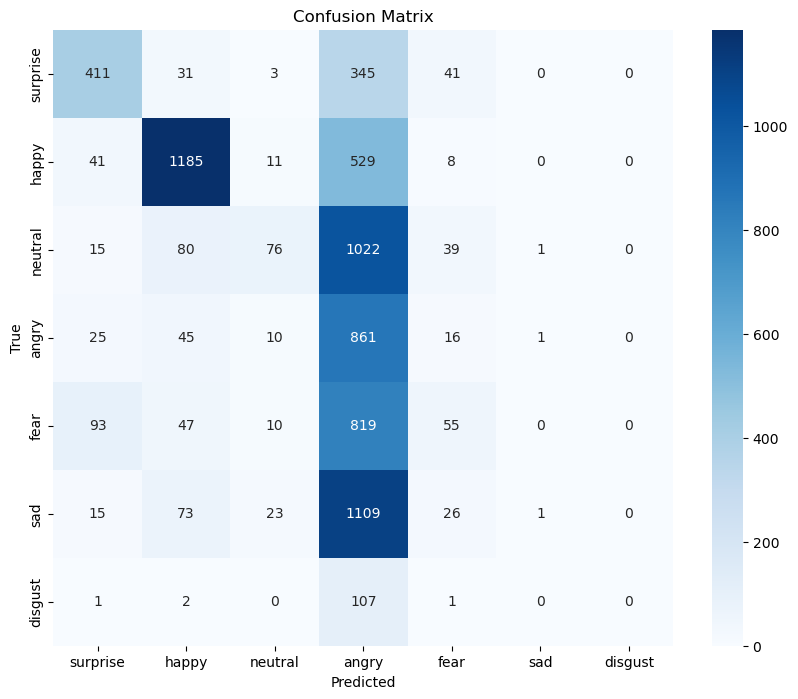

In [63]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()